# Future Prediction on Exercise Datasets

In [1]:
import sys
sys.path.append('..')
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from util.tf_ops import *

from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
exe_train = get_collection("../data/exercise-128x128/train")
total_train = sum([x.shape[0] for x in exe_train])
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(len(exe_train), total_train))

{'images:': 'Exercise-Train-01', 'dim': (3442, 128, 128, 3)}
{'images:': 'Exercise-Train-02', 'dim': (7134, 128, 128, 3)}
{'images:': 'Exercise-Train-03', 'dim': (7710, 128, 128, 3)}
{'images:': 'Exercise-Train-04', 'dim': (4646, 128, 128, 3)}
{'images:': 'Exercise-Train-05', 'dim': (5258, 128, 128, 3)}
{'images:': 'Exercise-Train-06', 'dim': (5304, 128, 128, 3)}
{'images:': 'Exercise-Train-07', 'dim': (4488, 128, 128, 3)}
{'images:': 'Exercise-Train-08', 'dim': (7050, 128, 128, 3)}
{'images:': 'Exercise-Train-09', 'dim': (4838, 128, 128, 3)}
{'images:': 'Exercise-Train-10', 'dim': (4874, 128, 128, 3)}
{'images:': 'Exercise-Train-11', 'dim': (5446, 128, 128, 3)}
{'images:': 'Exercise-Train-12', 'dim': (4772, 128, 128, 3)}
{'images:': 'Exercise-Train-13', 'dim': (8560, 128, 128, 3)}
{'images:': 'Exercise-Train-14', 'dim': (4726, 128, 128, 3)}
{'images:': 'Exercise-Train-15', 'dim': (2822, 128, 128, 3)}
{'images:': 'Exercise-Train-16', 'dim': (4394, 128, 128, 3)}
{'images:': 'Exercise-Tr

In [6]:
exe_test = get_collection("../data/exercise-128x128/test/")
total_test = sum([x.shape[0] for x in exe_test])
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(len(exe_test), total_test))

{'images:': 'Exercise-Test-12', 'dim': (1000, 128, 128, 3)}

After Augmentation: img_collections has 1 collections, 1000 images in total


In [7]:
def sample(collection, batch_size = 8):
    """
    Input:
        collection: [img_data] - list of ndarray
    Output:
        before_imgs, after_img - [batch size, 32, 32]
    """
    np.random.shuffle(collection)
    # get average number of training for each class
    n_collection = len(collection)
    num_per_collection = [x.shape[0] for x in collection]
    avg_num_per_class = 2 * int(np.ceil(batch_size/n_collection))
    # before-index for each class
    before_ind = []
    for i, imgs in enumerate(collection):
        try:
            s = np.random.choice(range(0, num_per_collection[i] - 1, 2), avg_num_per_class, replace=False)
            before_ind.append(s)
        except: # if not enough in this class
            before_ind.append(np.array([]))
    # after-index for each class
    after_ind = [x+1 for x in before_ind]
    
    selected_classes = [i for i in range(n_collection) if before_ind[i].shape[0]>0]
    before_imgs = np.concatenate([collection[i][before_ind[i]] for i in selected_classes], axis = 0)
    after_imgs = np.concatenate([collection[i][after_ind[i]] for i in selected_classes], axis = 0)
    
    before_imgs = before_imgs[:batch_size]
    after_imgs = after_imgs[:batch_size]
    assert len(before_imgs) == batch_size
    assert len(after_imgs) == batch_size
    return before_imgs, after_imgs


def sample_train(batch_size = 8): return sample(exe_train, batch_size)

def sample_test(batch_size = 8):  return sample(exe_test, batch_size)

Range of Image Piece Value: [0, 255]
Before: (6, 128, 128, 3)
After:  (6, 128, 128, 3)


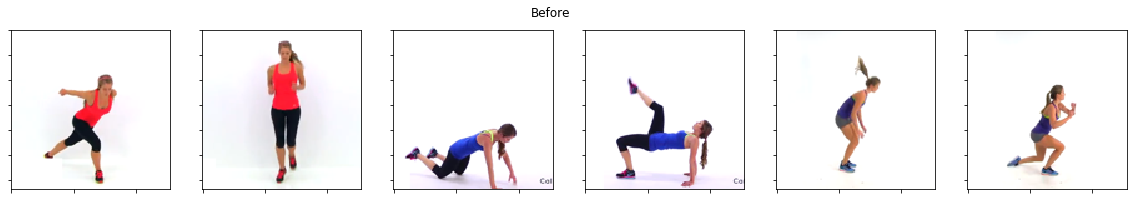

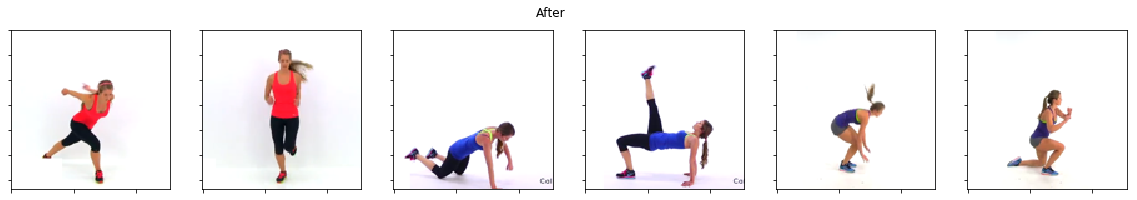

In [10]:
def show_sample_train(batch_size):
    before, after = sample_train(batch_size=batch_size)
    print("Range of Image Piece Value: [{}, {}]".format(np.min(before), np.max(before)))
    print("Before: {}".format(before.shape))
    print("After:  {}".format(after.shape))
    size = (20, 3)
    plot_images(before, size, "Before")
    plot_images(after, size, "After")
    
show_sample_train(batch_size = 6)